![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

In [617]:
import numpy as np
import pandas as pd

import pickle

from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, precision_recall_curve, auc

from keras.utils import np_utils

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.callbacks import TensorBoard

In [618]:
# import configurations (file paths, etc.)
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
    
configFile = '../cluster/data/medinfmk/ddi/config/config.yml'

with open(configFile, 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=Loader)

In [619]:
pathInput = cfg['filePaths']['dirRaw']
pathOutput = cfg['filePaths']['dirProcessed']
# path to store python binary files (pickles)
# in order not to recalculate them every time
pathPickles = cfg['filePaths']['dirProcessedFiles']['dirPickles']
pathRuns = cfg['filePaths']['dirProcessedFiles']['dirRuns']
pathPaperScores = cfg['filePaths']['dirRawFiles']['paper-individual-metrics-scores']
datasetDirs = cfg['filePaths']['dirRawDatasets']
DS1_path = str(datasetDirs[0])

# Helper Functions

In [620]:
def prepare_data(input_fea, input_lab, seperate=False):
    offside_sim_path = input_fea
    drug_interaction_matrix_path = input_lab
    drug_fea = np.loadtxt(offside_sim_path,dtype=float,delimiter=",")
    interaction = np.loadtxt(drug_interaction_matrix_path,dtype=int,delimiter=",")
    
    train = []
    label = []
    tmp_fea=[]
    drug_fea_tmp = []
            
    for i in range(0, (interaction.shape[0]-1)):
        for j in range((i+1), interaction.shape[1]):
            label.append(interaction[i,j])
            drug_fea_tmp_1 = list(drug_fea[i])
            drug_fea_tmp_2 = list(drug_fea[j])
            if seperate:
                 tmp_fea = (drug_fea_tmp_1,drug_fea_tmp_2)
            else:
                 tmp_fea = drug_fea_tmp_1 + drug_fea_tmp_2
            train.append(tmp_fea)

    return np.array(train), np.array(label)

In [621]:
def transfer_array_format(data):
    formated_matrix1 = []
    formated_matrix2 = []
    for val in data:
        formated_matrix1.append(val[0])
        formated_matrix2.append(val[1])
    return np.array(formated_matrix1), np.array(formated_matrix2)

In [622]:
def preprocess_labels(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
        y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
        print(y)
    return y, encoder

In [623]:
def preprocess_names(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    if categorical:
        labels = np_utils.to_categorical(labels)
    return labels, encoder

In [624]:
def do_stratifiedKFold(X,y,n_splits):
    skf = StratifiedKFold(n_splits=n_splits)
    skf.get_n_splits(X, y)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

In [625]:
class NDD(nn.Module):
    def __init__(self, D_in=123, H1=300, H2=400, D_out=2, drop=0.5):
        super(NDD, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(D_in, H1) # Fully Connected
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, D_out)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [626]:
def updateSimilarityDFSingleMetric(df, sim_type, metric, value):
    df.loc[df['Similarity'] == sim_type, metric ] = value
    return df

In [627]:
def updateSimilarityDF(df, sim_type, AUROC, AUPR, F1, Rec, Prec):
    df = updateSimilarityDFSingleMetric(df, sim_type, 'AUC', AUROC)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'AUPR', AUPR)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'F-measure', F1)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'Recall', Rec)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'Precision', Prec)
    return df

In [628]:
def getNetParamsStr(net, str_hidden_layers_params, net_params_to_print=["max_epochs", "batch_size"]):
    net_params = [val for sublist in [[x,net.get_params()[x]] for x in net_params_to_print] for val in sublist]
    net_params_str = '-'.join(map(str, flattened))
    return(net_params_str+str_hidden_layers_params)

In [629]:
def writeReplicatedIndividualScoresCSV(net, df, destination, str_hidden_layers_params):
    filePath = destination + "replicatedIndividualScores_" + getNetParamsStr(net, str_hidden_layers_params) + ".csv"
    df.to_csv(path_or_buf = filePath, index=False)

In [630]:
def getNDDClassifier():
    net = NeuralNetClassifier(
        model,
        criterion=nn.CrossEntropyLoss,
        max_epochs=20,
        optimizer=SGD,
        optimizer__lr=0.01,
        optimizer__momentum=0.9,    
        optimizer__weight_decay=1e-6,    
        optimizer__nesterov=True,    
        batch_size=200,
        callbacks=callbacks,
        # Shuffle training data on each epoch
        iterator_train__shuffle=True,
        device=device,
    )
    return net

# Run

In [631]:
df_paperIndividualScores = pd.read_csv(pathPaperScores)

df_replicatedIndividualScores = df_paperIndividualScores.copy()

for col in df_replicatedIndividualScores.columns:
    if col != 'Similarity':
        df_replicatedIndividualScores[col].values[:] = 0

In [632]:
do_prepare_data = False
do_train_model = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
soft = nn.Softmax(dim=1)
similaritiesToRun = df_paperIndividualScores['Similarity']
# similaritiesToRun = ["chem"]

for similarity in similaritiesToRun:
    input_fea = pathInput+DS1_path+"/" + similarity + "_Jacarrd_sim.csv"
    input_lab = pathInput+DS1_path+"/drug_drug_matrix.csv"
    dataPicklePath = pathPickles+"data_X_y_" + similarity + "_Jaccard.p"

    # Prepare data if not available
    if do_prepare_data:
        X,y = prepare_data(input_fea, input_lab, seperate = False)

        with open(dataPicklePath, 'wb') as f:
            pickle.dump([X, y], f)

    # Load X,y and split in to train, test
    with open(dataPicklePath, 'rb') as f:
        X, y = pickle.load(f)
    
    X = X.astype(np.float32)
    y = y.astype(np.int64)    
    X_train, X_test, y_train, y_test = do_stratifiedKFold(X,y,n_splits=5)
    
    # Define model
    D_in, H1, H2, D_out, drop = X.shape[1], 300, 400, 2, 0.5
    str_hidden_layers_params = "-H1-" + str(H1) + "-H2-" + str(H2)
    model = NDD(D_in, H1, H2, D_out, drop)
    callbacks = []

    # Create Network Classifier
    net = getNDDClassifier()
    
    # Fit and save OR load model
    modelPicklePath = pathPickles+"model_params/model_params" + str_hidden_layers_params+ "_" + similarity + ".p"
    if do_train_model:
        net.fit(X_train, y_train)
        net.save_params(f_params=modelPicklePath)
    else:
        net.initialize()  # This is important!
        net.load_params(f_params=modelPicklePath)
    
    # Make predictions
    y_pred = net.predict(X_test)
    lr_probs = soft(net.forward(X_test))[:,1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

    AUROC, AUPR, F1, Rec, Prec = roc_auc_score(y_test, y_pred), auc(lr_recall, lr_precision), f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)
    print(similarity, AUROC, AUPR, F1, Rec, Prec)
    
    # Fill replicated metrics
    updateSimilarityDF(df_replicatedIndividualScores, similarity, AUROC, AUPR, F1, Rec, Prec)
    
# Write CSV
writeReplicatedIndividualScoresCSV(net, df_replicatedIndividualScores, pathRuns, str_hidden_layers_params)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6282       0.6758        0.6275  1.8856
      2        0.6193       0.6758        0.6263  1.9687
      3        0.6129       0.6757        0.6240  1.9318
      4        0.6083       0.6758        0.6225  1.9810
      5        0.6058       0.6758        0.6183  2.2694
      6        0.6060       0.6758        0.6209  2.3240
      7        0.6051       0.6785        0.6244  1.9642
      8        0.6099       0.6758        0.6277  1.9450
      9        0.6135       0.6758        0.6258  1.9368
     10        0.6115       0.6758        0.6281  2.3649
     11        0.6142       0.6758        0.6236  2.3829
     12        0.6101       0.6758        0.6256  2.0743
     13        0.6122       0.6765        0.6254  1.9104
     14        0.6102       0.6758        0.6284  2.0027
     15        0.6147       0.6760        0.6265  1.8768
     16        0.6137       0.6

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6263       0.6763        0.6222  1.9948
      2        0.5671       0.6776        0.6052  1.7262
      3        0.4632       0.6928        0.6081  1.7099
      4        0.4117       0.6966        0.6228  1.9381
      5        0.3903       0.7193        0.6164  2.2947
      6        0.3763       0.7182        0.6075  2.2652
      7        0.3680       0.7322        0.5805  1.9988
      8        0.3597       0.7237        0.6210  1.9513
      9        0.3543       0.7334        0.6054  2.0734
     10        0.3482       0.7206        0.6363  1.9586
     11        0.3453       0.7299        0.6255  2.0317
     12        0.3406       0.7350        0.6227  2.1263
     13        0.3371       0.7432        0.6063  2.0932
     14        0.3334       0.7274        0.6342  2.0542
     15        0.3302       0.7324        0.6558  2.0120
     16        0.3254       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6071       0.6772        0.6157  2.1323
      2        0.5718       0.6863        0.6270  2.2506
      3        0.5447       0.6790        0.6336  1.9920
      4        0.5270       0.6889        0.6335  1.9485
      5        0.5168       0.7058        0.6197  1.9478
      6        0.5117       0.6987        0.6120  1.9184
      7        0.5083       0.7106        0.6182  2.0045
      8        0.5038       0.7124        0.6103  1.8930
      9        0.5001       0.7146        0.5951  1.9484
     10        0.4986       0.7147        0.6053  1.9508
     11        0.4962       0.7149        0.6065  1.9645
     12        0.4949       0.7182        0.6056  1.9803
     13        0.4921       0.7163        0.6216  2.4544
     14        0.4909       0.7189        0.6012  2.4782
     15        0.4896       0.7071        0.5940  2.4195
     16        0.4895       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6032       0.6944        0.5962  1.9283
      2        0.5507       0.7195        0.5783  1.9585
      3        0.5073       0.7070        0.5874  1.9754
      4        0.4852       0.7086        0.5854  1.9709
      5        0.4739       0.7126        0.5895  1.9919
      6        0.4665       0.7112        0.5742  1.9667
      7        0.4587       0.7053        0.5936  1.8940
      8        0.4548       0.7056        0.5845  2.0745
      9        0.4522       0.7239        0.5707  2.4746
     10        0.4473       0.7075        0.5918  2.4969
     11        0.4453       0.7090        0.5987  2.4004
     12        0.4428       0.7141        0.5770  2.0331
     13        0.4408       0.7142        0.5765  1.9544
     14        0.4382       0.7107        0.5978  1.9556
     15        0.4374       0.7099        0.6008  1.9993
     16        0.4345       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6141       0.6765        0.6201  1.9416
      2        0.5464       0.6993        0.6066  1.9777
      3        0.4890       0.6458        0.6537  1.9733
      4        0.4609       0.6668        0.6459  1.9491
      5        0.4434       0.6306        0.7027  1.9387
      6        0.4310       0.6777        0.6466  1.9670
      7        0.4236       0.7091        0.5999  1.9494
      8        0.4145       0.7065        0.6160  1.9262
      9        0.4096       0.7193        0.6062  1.9442
     10        0.4018       0.6727        0.6833  2.0204
     11        0.3979       0.7252        0.6207  1.9761
     12        0.3923       0.6782        0.6905  2.0944
     13        0.3904       0.6910        0.6722  2.0765
     14        0.3871       0.6763        0.6725  1.9439
     15        0.3858       0.7263        0.6148  2.1945
     16        0.3826       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5849       0.7114        0.5755  2.0112
      2        0.4560       0.7126        0.5661  1.9632
      3        0.3821       0.7184        0.5822  1.9861
      4        0.3459       0.7154        0.6193  1.9896
      5        0.3250       0.7073        0.6644  1.9981
      6        0.3102       0.7113        0.6807  1.9921
      7        0.3014       0.7110        0.6893  1.9866
      8        0.2937       0.7239        0.6657  2.0125
      9        0.2849       0.7173        0.6897  1.9327
     10        0.2795       0.7234        0.6835  1.9823
     11        0.2753       0.7196        0.7187  1.9915
     12        0.2707       0.7236        0.6964  1.9750
     13        0.2681       0.7210        0.7082  1.9986
     14        0.2619       0.7206        0.7338  1.9770
     15        0.2604       0.7263        0.7048  2.0100
     16        0.2569       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5889       0.6937        0.5844  1.9909
      2        0.5545       0.7007        0.5897  2.0091
      3        0.5338       0.6892        0.6064  1.9662
      4        0.5229       0.6843        0.6553  1.9431
      5        0.5228       0.7064        0.5818  1.9515
      6        0.5195       0.7077        0.5773  2.0358
      7        0.5190       0.7151        0.5678  2.0173
      8        0.5180       0.7239        0.5647  1.9607
      9        0.5225       0.6943        0.5895  1.9713
     10        0.5205       0.6899        0.5883  1.9248
     11        0.5230       0.7018        0.5733  2.3681
     12        0.5263       0.6959        0.5850  2.3733
     13        0.5230       0.6979        0.5809  2.3845
     14        0.5288       0.7123        0.5889  2.4455
     15        0.5237       0.6913        0.5957  2.4473
     16        0.5330       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5733       0.7043        0.5590  1.9715
      2        0.5077       0.7405        0.5121  1.9644
      3        0.4757       0.7614        0.5002  1.9753
      4        0.4632       0.6963        0.5299  1.9086
      5        0.4596       0.7621        0.4986  1.9622
      6        0.4606       0.7689        0.4818  1.9600
      7        0.4656       0.7177        0.5599  1.9635
      8        0.4626       0.7661        0.4855  1.9532
      9        0.4627       0.7526        0.5011  1.9567
     10        0.4617       0.7133        0.5354  1.9622
     11        0.4587       0.7101        0.5354  1.9446
     12        0.4585       0.7144        0.5286  1.7510
     13        0.4705       0.7515        0.5130  1.7364
     14        0.4766       0.7691        0.4848  1.6991
     15        0.4741       0.7174        0.5372  1.7114
     16        0.4740       0.7

# Compare to Paper

In [633]:
print(df_paperIndividualScores)

      Similarity    AUC   AUPR  F-measure  Recall  Precision
0           chem  0.631  0.455      0.527   0.899      0.373
1         target  0.787  0.642      0.617   0.721      0.540
2    transporter  0.682  0.568      0.519   0.945      0.358
3         enzyme  0.734  0.599      0.552   0.579      0.529
4        pathway  0.767  0.623      0.587   0.650      0.536
5     indication  0.802  0.654      0.632   0.740      0.551
6     sideeffect  0.778  0.601      0.619   0.748      0.528
7  offsideeffect  0.782  0.606      0.617   0.764      0.517


In [634]:
print(df_replicatedIndividualScores)

      Similarity       AUC      AUPR  F-measure    Recall  Precision
0           chem  0.503428  0.370788   0.016485  0.008337   0.729730
1         target  0.636575  0.482254   0.510044  0.514821   0.505355
2    transporter  0.592948  0.420822   0.444103  0.431762   0.457171
3         enzyme  0.617628  0.496778   0.520454  0.672396   0.424524
4        pathway  0.597748  0.446257   0.469358  0.503705   0.439397
5     indication  0.684966  0.608291   0.579857  0.628139   0.538468
6     sideeffect  0.550063  0.352792   0.500990  0.872375   0.351395
7  offsideeffect  0.741223  0.707531   0.649695  0.882565   0.514058


In [635]:
diff_metrics = ['AUC', 'AUPR', 'F-measure', 'Recall', 'Precision']
df_diff = df_paperIndividualScores[diff_metrics] - df_replicatedIndividualScores[diff_metrics]
df_diff_abs = df_diff.abs()
df_diff_percent = (df_diff_abs / df_paperIndividualScores[diff_metrics]) * 100

In [636]:
df_diff

,AUC,AUPR,F-measure,Recall,Precision
0,0.127572,0.084212,0.510515,0.890663,-0.356730
1,0.150425,0.159746,0.106956,0.206179,0.034645
2,0.089052,0.147178,0.074897,0.513238,-0.099171
3,0.116372,0.102222,0.031546,-0.093396,0.104476
4,0.169252,0.176743,0.117642,0.146295,0.096603
5,0.117034,0.045709,0.052143,0.111861,0.012532
6,0.227937,0.248208,0.118010,-0.124375,0.176605
7,0.040777,-0.101531,-0.032695,-0.118565,0.002942


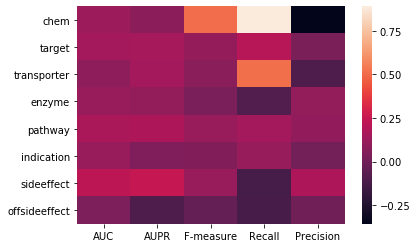

In [637]:
from seaborn import heatmap
heatmap(df_diff, yticklabels=df_paperIndividualScores["Similarity"])

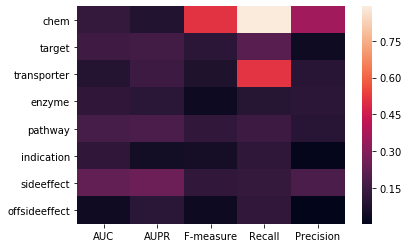

In [638]:
heatmap(df_diff_abs, yticklabels=df_paperIndividualScores["Similarity"])

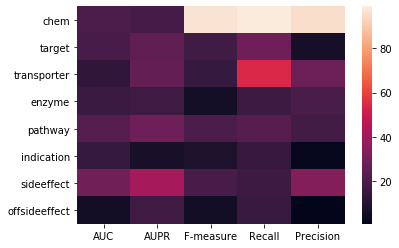

In [639]:
heatmap(df_diff_percent, yticklabels=df_paperIndividualScores["Similarity"])

In [640]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_paperIndividualScores[['AUC', 'AUPR', 'F-measure', 'Recall', 'Precision']],
                   df_replicatedIndividualScores[['AUC', 'AUPR', 'F-measure', 'Recall', 'Precision']])

0.04994464020124655